In [1]:
import numpy as np
from datetime import datetime

import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Read in datasets
- Use pandas  to read in the datasets <br>
- Use boolean marking for the data: 0 for fake, 1 for true.
- Create combined dataset df

In [2]:
fake_df = pd.read_csv('dataset/Fake.csv')
true_df = pd.read_csv('dataset/True.csv')

fake_df['label'] = 0
true_df['label'] = 1

df = pd.concat([fake_df, true_df], ignore_index=True)
print(df.columns)

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


# Explore dataset
## a) Evaluate the 'subject' column
There is no consistent labeling of subjects between the 2 datasets. On top of that the labels in both categories are ambiguous as some are synonymous and others could easily overlap with eachother.

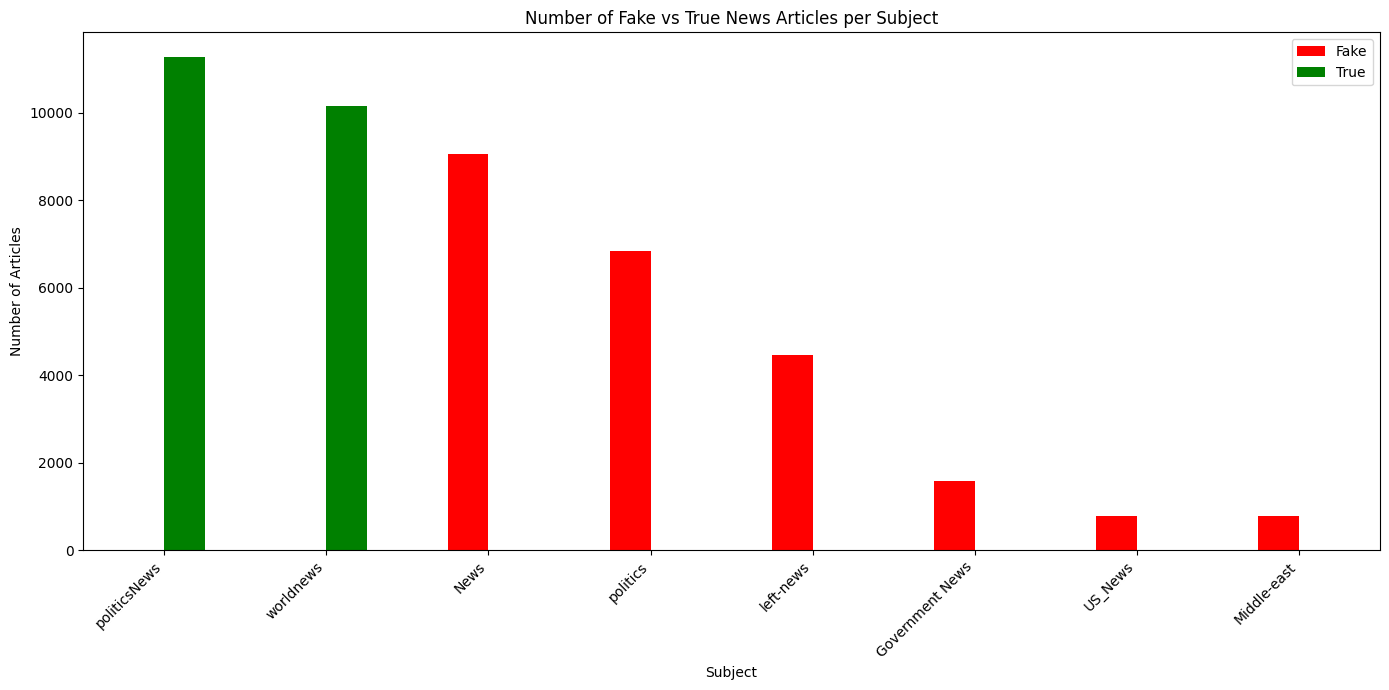

In [3]:
#count the subjects in both datasets seperately
fake_counts = df[df['label'] == 0]['subject'].value_counts()
true_counts = df[df['label'] == 1]['subject'].value_counts()

counts_df = pd.DataFrame({
    'Fake': fake_counts,
    'True': true_counts
}).fillna(0)

counts_df['Total'] = counts_df['Fake'] + counts_df['True']
counts_df = counts_df.sort_values('Total', ascending=False)

counts_df = counts_df.drop(columns='Total')
counts_df.plot(kind='bar', figsize=(14,7), color=['red', 'green'])
plt.title('Number of Fake vs True News Articles per Subject')
plt.xlabel('Subject')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## b) Evaluate the 'date' column
The dates are formatted in several different ways. In order to plot them I convert them to a general format.
### Delete 10 inconsistent data items
It appears that the datasets has 10 instances which do not have valid date, and also do not have correct values for their text and titles. Instead, they have invalid links to webpages for all categories. I will remove these 10 data items from the set.

In [4]:
#strip extra spaces first
df['date_plot'] = df['date'].str.strip()

#define a parser that tries multiple formats
def parse_date(date_str):
    for fmt in ("%B %d, %Y", "%d-%b-%y", "%b %d, %Y"):
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    return pd.NaT  # Not a Time if all formats fail

#apply the parser
df['date_plot'] = df['date_plot'].apply(parse_date)

#check which rows failed
failing_rows = df[df['date_plot'].isna()]
N = failing_rows.shape[0]

print('\n')
print(f'Failed to read in the date for {N} cases')
if N > 0:
    print('Their text values are:')
    print(failing_rows[['date', 'text']])

#delete 10 datasets
df = df[df['date_plot'].notna()].reset_index(drop=True)



Failed to read in the date for 10 cases
Their text values are:
                                                    date  \
9358   https://100percentfedup.com/served-roy-moore-v...   
15507  https://100percentfedup.com/video-hillary-aske...   
15508  https://100percentfedup.com/12-yr-old-black-co...   
15839  https://fedup.wpengine.com/wp-content/uploads/...   
15840  https://fedup.wpengine.com/wp-content/uploads/...   
17432  https://fedup.wpengine.com/wp-content/uploads/...   
17433  https://fedup.wpengine.com/wp-content/uploads/...   
18933  MSNBC HOST Rudely Assumes Steel Worker Would N...   
21869  https://fedup.wpengine.com/wp-content/uploads/...   
21870  https://fedup.wpengine.com/wp-content/uploads/...   

                                                    text  
9358   https://100percentfedup.com/served-roy-moore-v...  
15507  https://100percentfedup.com/video-hillary-aske...  
15508  https://100percentfedup.com/12-yr-old-black-co...  
15839  https://fedup.wpengine.com/wp-c

### ii) Evaluate the distribution in dates for both datasets
- The true dataset is overly represented in the period after September 2017, which could cause a bias in topics represented between True and False news items. There are also no True articles from before 2016.
- The cell below further illustrates this by showing how news items are distributed over time when they contain a specific word in their title or text.
- 'Korea', 'Brexit' and 'govt' occur a lot in the dataset after 2017-09, while 'Obama' is more represented before 2017-09. In the code you can replace the keywords with any other words you want to investigate.

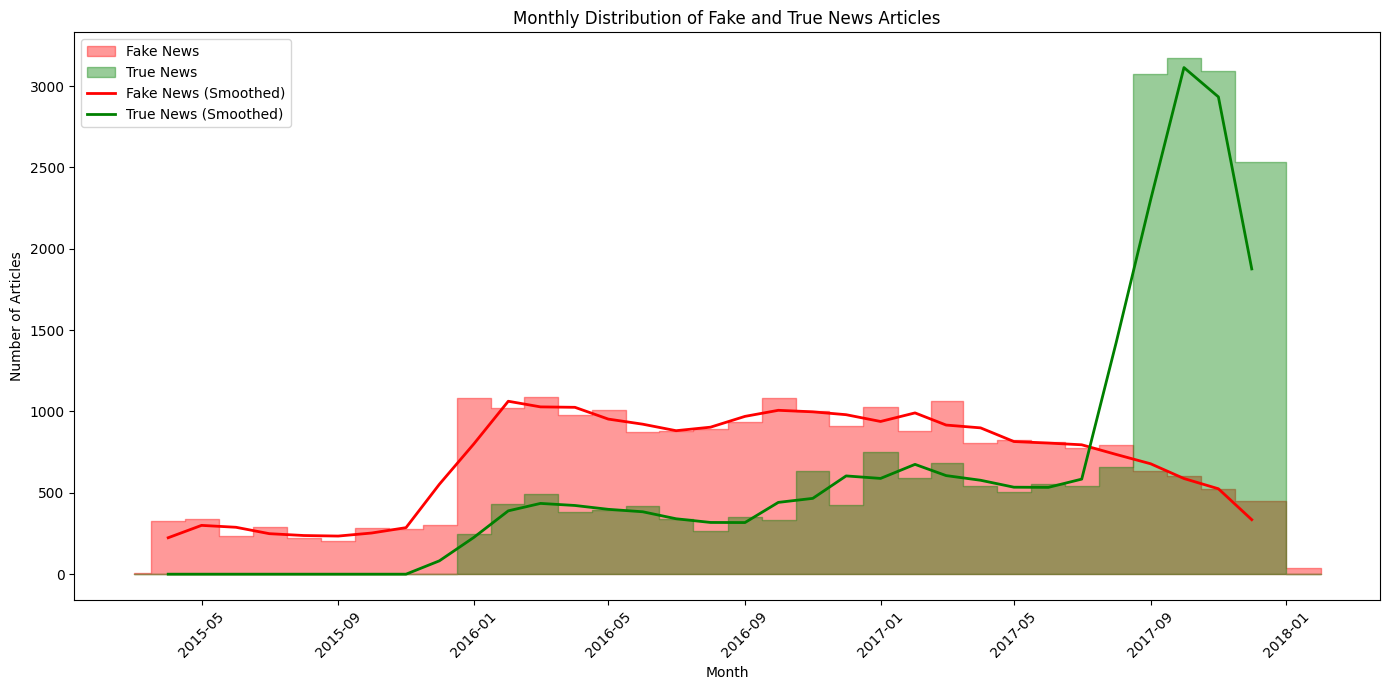

In [5]:
df['date_plot'] = pd.to_datetime(df['date_plot'], format='%B %d, %Y')
df['year_month'] = df['date_plot'].dt.to_period('M').astype(str)

counts = df.groupby(['year_month', 'label']).size().unstack(fill_value=0)
counts = counts.sort_index()

fake_counts = counts[0]
true_counts = counts[1]

x = pd.to_datetime(counts.index.to_list(), format='%Y-%m')

plt.figure(figsize=(14,7))
plt.fill_between(x, fake_counts, step='mid', alpha=0.4, label='Fake News', color='r')
plt.fill_between(x, true_counts, step='mid', alpha=0.4, label='True News', color='g')

fake_smooth = fake_counts.rolling(window=3, center=True).mean()
true_smooth = true_counts.rolling(window=3, center=True).mean()

plt.plot(x, fake_smooth, color='r', label='Fake News (Smoothed)', linewidth=2)
plt.plot(x, true_smooth, color='g', label='True News (Smoothed)', linewidth=2)

plt.title('Monthly Distribution of Fake and True News Articles')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

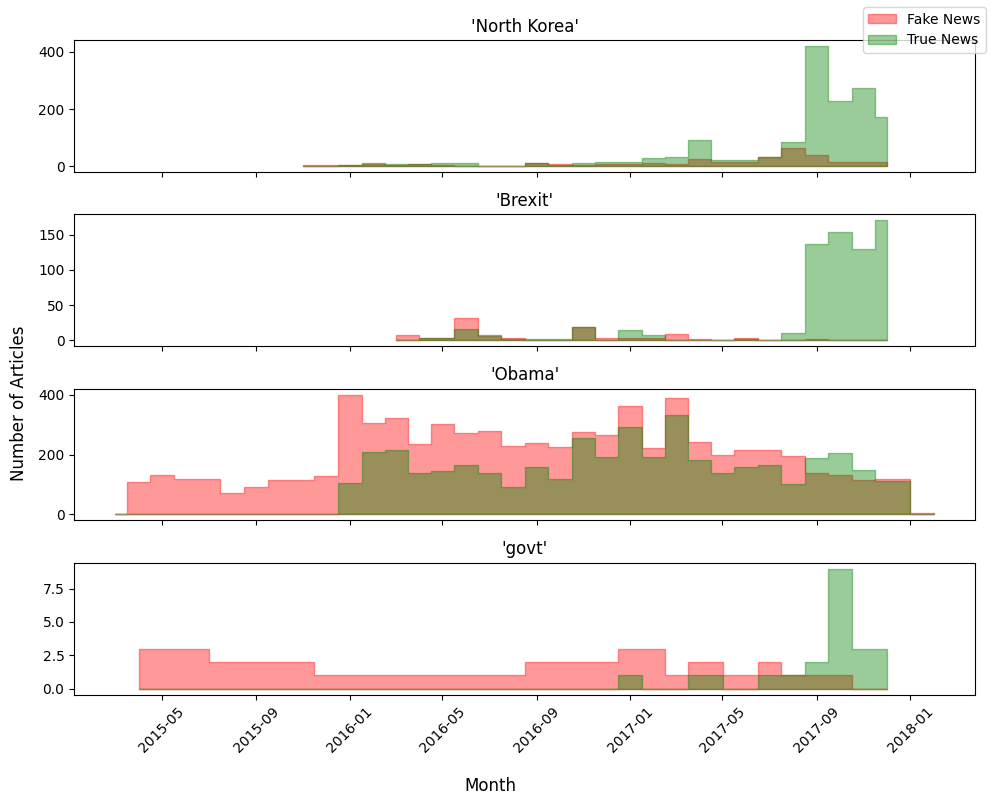

In [6]:
def plot_news_distribution_subplot(ax, df, keyword):
    # Filter rows containing the keyword (case-insensitive)
    mask = df['text'].str.contains(keyword, case=False, na=False) | df['title'].str.contains(keyword, case=False, na=False)
    df_filtered = df[mask]

    if df_filtered.empty:
        ax.set_title(f"No entries for '{keyword}'")
        return

    #convert date column and extract year-month if not already done
    if 'year_month' not in df_filtered.columns:
        df_filtered['date_plot'] = pd.to_datetime(df_filtered['date_plot'], format='%B %d, %Y')
        df_filtered['year_month'] = df_filtered['date_plot'].dt.to_period('M').astype(str)

    #group and count
    counts = df_filtered.groupby(['year_month', 'label']).size().unstack(fill_value=0).sort_index()
    fake_counts = counts.get(0, pd.Series(0, index=counts.index))
    true_counts = counts.get(1, pd.Series(0, index=counts.index))

    x = pd.to_datetime(counts.index.to_list(), format='%Y-%m')

    ax.fill_between(x, fake_counts, step='mid', alpha=0.4, label='Fake News', color='r')
    ax.fill_between(x, true_counts, step='mid', alpha=0.4, label='True News', color='g')

    ax.set_title(f"'{keyword}'")

#replace these words with any you want
keywords = ["North Korea", "Brexit", "Obama", "govt"]
fig, axes = plt.subplots(len(keywords), 1, figsize=(10, 8), sharex=True)

for ax, keyword in zip(axes, keywords):
    plot_news_distribution_subplot(ax, df, keyword)

#create a shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize='medium')

fig.supxlabel("Month")
fig.supylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()  #adjust layout to fit title
plt.show()

# 5: Preprocess data
- In the LSTM I will train solely on the text content. One could consider adding the title and possibly the date as extra features, but I find that this more simple approach gives good results.
- After trying a maximum vocabulary of 5,000, 10,000 and 20,000 words I find that the best results on the validation set are obtained with max_vocab = 10000.
- This vocabulary covers roughly 95% of the text. The 10,000th word occurs 104 times in the texts.

The dataset is split into:
- 80% training data
- 10% validation data, which I use to finetune model parameters
- 10% test data, which I do not use until the final evaluation

In [7]:
max_vocab = 10000

X = df['text'].values
y = df['label'].values

#set new tokenizer
tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

sorted_counts = np.array(sorted(tokenizer.word_counts.values(), reverse=True))
cumulative_counts = np.cumsum(sorted_counts)

print(f"Total vocabulary size: {len(tokenizer.word_index)}")
print(f"When using a maximum vocab of {max_vocab}, this will cover {np.round(100 * (cumulative_counts[max_vocab - 1] / cumulative_counts[-1]), 2)}% of the text.")
print(f"The {max_vocab}th word occurs {sorted_counts[max_vocab - 1]} times in the texts.")

sequences = tokenizer.texts_to_sequences(X)
padded = pad_sequences(sequences, maxlen=30, padding='post', truncating='post')

#split 80% of the data into a training set
X_train, X_rest, y_train, y_rest = train_test_split(padded, y, test_size=0.2)

#split the rest of the data into 50% validation data and 50% test data.
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

Total vocabulary size: 138015
When using a maximum vocab of 10000, this will cover 94.49% of the text.
The 10000th word occurs 104 times in the texts.


# 6: Buid the model
- output_dim = 16. I use 16 dimensions for the embedding vectors.
- input_shape=(30,) creates a fixed token length of 30, which is long enough for most sentences.
- In combination with a sequence of 30 tokes, an LSTM of 64 units is a good balance between the capacity to learn without becoming computationally expensive. I do find that this layer benefits from a recurrent dropout in order to prevent overfitting.
- A second standard dropout layer prevents overfitting on learned features.
- A dense layer with a Rectified linear unit (ReLU) as an activation function, introducing non-linearity. This helps the model better capture how features combine to determine the classification.
- The sigmoid layer converts values on the range [0, 1], so we can compare to our binary classification of 0 and 1.
- 'binary_crossentropy' is a suitable loss function for binary classifications.
- 'adam' performs well as an optimizer, I did not try any other ones.

In [8]:
model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=16, input_shape=(30,)),
    LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

c:\Users\rishi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 30, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,793 (710.13 KB)

 Trainable params: 181,793 (710.13 KB)

 Non-trainable params: 0 (0.00 B)

# 7: Training
Training is done for 5 epochs. At this point:
- The accuracy on the training data is still increasing and the loss on training data is dropping notably.
- The validation accuracy and loss are stable.
- The performance on both the training and validation data is similar, thus avoiding overfitting.

In [9]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.8806 - loss: 0.2028 - val_accuracy: 0.9935 - val_loss: 0.0245
Epoch 2/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - accuracy: 0.9972 - loss: 0.0127 - val_accuracy: 0.9987 - val_loss: 0.0077
Epoch 3/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - accuracy: 0.9992 - loss: 0.0053 - val_accuracy: 0.9984 - val_loss: 0.0046
Epoch 4/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - accuracy: 0.9992 - loss: 0.0063 - val_accuracy: 0.9989 - val_loss: 0.0086
Epoch 5/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - accuracy: 0.9993 - loss: 0.0044 - val_accuracy: 0.9989 - val_loss: 0.0092


# 8: Evaluation
## a) Accuracy & Loss
The figures below vizualize the accuracy and loss of both the training and validation data, which are also given in the output above. 

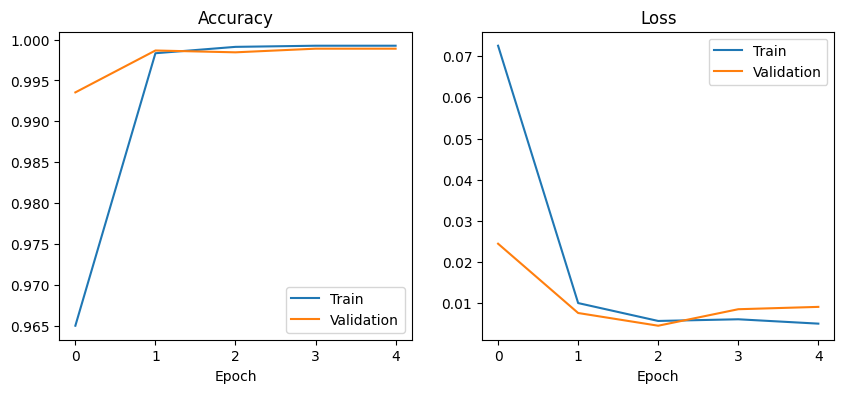

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()
plt.show()

## b) Confusion Matrix
The final model performs well on the test data.

141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2394
           1       1.00      1.00      1.00      2095

    accuracy                           1.00      4489
   macro avg       1.00      1.00      1.00      4489
weighted avg       1.00      1.00      1.00      4489



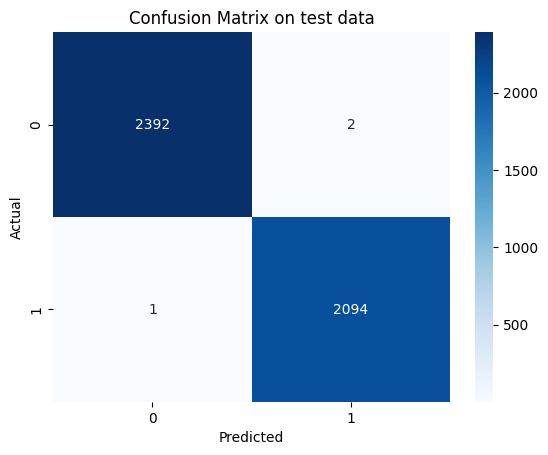

In [11]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()